In [1]:
# Import necessary libraries
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from model.maxsr_super_tiny import *

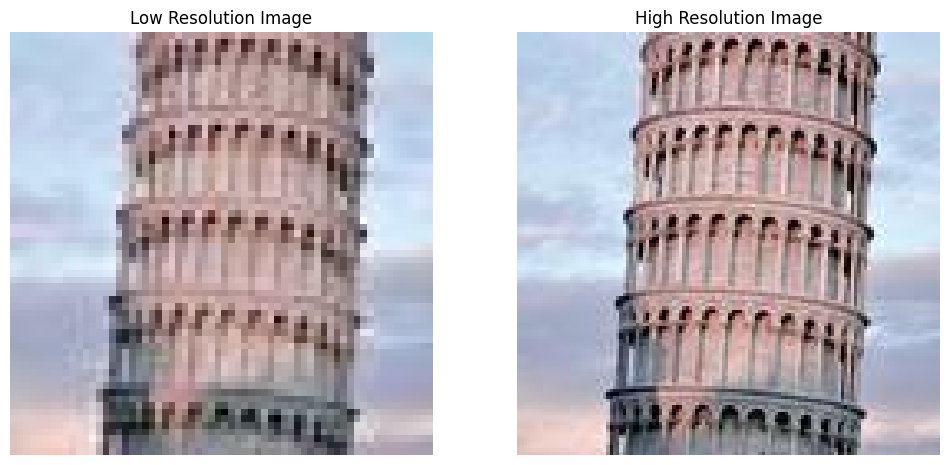

In [2]:
# Load the images
lr_image_path = '/home/linuxu/Documents/datasets/Tiny_LR/21.jpeg'  
hr_image_path = '/home/linuxu/Documents/datasets/Tiny_HR/21.jpeg'  

lr_image = Image.open(lr_image_path)
hr_image = Image.open(hr_image_path)

# Plot the images side by side
plt.figure(figsize=(12, 6))

# Plot Low Resolution Image
plt.subplot(1, 2, 1)
plt.imshow(lr_image)
plt.title('Low Resolution Image')
plt.axis('off')

# Plot High Resolution Image
plt.subplot(1, 2, 2)
plt.imshow(hr_image)
plt.title('High Resolution Image')
plt.axis('off')

plt.show()

In [3]:
# Transform the image to tensor
transform = transforms.ToTensor()
image_tensor = transform(lr_image).unsqueeze(0)

# Output the shape of the tensor
print(f'The shape of the low resolution tensor is: {image_tensor.shape}')

The shape of the low resolution tensor is: torch.Size([1, 3, 64, 64])


In [4]:
sfeb = ShallowFeatureExtractor()
sfeb_output = sfeb(image_tensor)

# SFEB OUTPUT

In [5]:
sfeb_output.shape

torch.Size([1, 64, 64, 64])

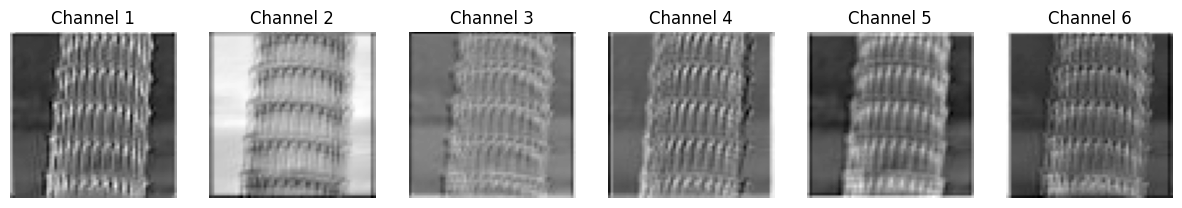

In [6]:
# Plot some of the channels
num_channels_to_plot = 6  # Adjust this to plot more or fewer channels
plt.figure(figsize=(15, 10))

for i in range(num_channels_to_plot):
    plt.subplot(1, num_channels_to_plot, i+1)
    plt.imshow(sfeb_output[0, i].detach().numpy(), cmap='gray')
    plt.title(f'Channel {i+1}')
    plt.axis('off')

plt.show()

# Patches

In [7]:
# Step 2: Extract Patches
patch_size = 8
patches = extract_patches(sfeb_output, patch_size)

In [8]:
patches.shape

torch.Size([1, 64, 64, 8, 8])

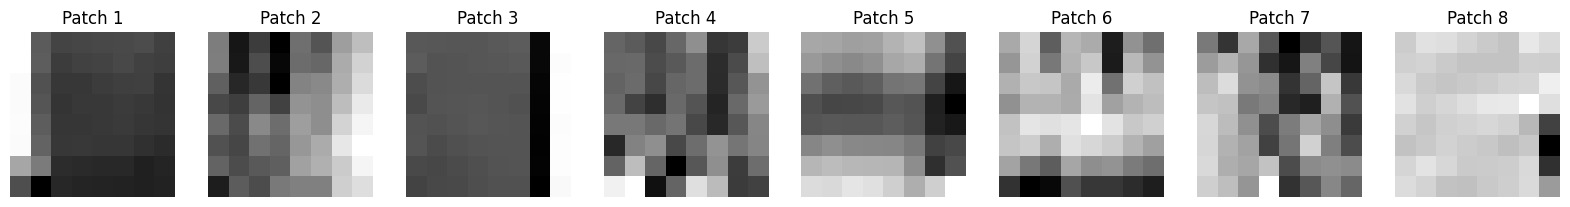

In [9]:
# Assuming patches have shape (1, 64, 64, 8, 8)
# Remove the batch dimension
patches = patches.squeeze(0)  # Shape is now (64, 64, 8, 8)

# Plot some of the patches
num_patches_to_plot = 8  # Adjust this number to plot more or fewer patches
plt.figure(figsize=(20, 5))

for i in range(num_patches_to_plot):
    # Select a patch and a random channel (e.g., channel 0)
    random_channel = torch.randint(0, patches.shape[1], (1,)).item()
    patch = patches[i, random_channel, :, :]  # Select the i-th patch and a random channel
    plt.subplot(1, num_patches_to_plot, i + 1)
    plt.imshow(patch.detach().cpu().numpy(), cmap='gray')
    plt.title(f'Patch {i+1}')
    plt.axis('off')

plt.show()

# Patch Embedding

In [10]:
# return batch size
patches = patches.unsqueeze(0)

# Patch embedding layer
embed_dim = 256
patch_embeddings = nn.Linear(64 * patch_size * patch_size, embed_dim)

# Step 3: Flatten each patch and project to a fixed dimension

In [11]:

batch_size, channels, num_patches, _, _ = patches.shape
patches = patches.view(
    batch_size, channels, num_patches, -1
)  # Flatten each patch
patches = patches.permute(
    0, 2, 1, 3
).contiguous()  # Move channels to the right position
patches = patches.view(
    batch_size, num_patches, -1
)  # Final shape: (batch_size, num_patches, channels * patch_size^2)
embedded_patches = patch_embeddings(patches)  # Project to fixed dimension


In [12]:
embedded_patches.shape

torch.Size([1, 64, 256])

In [23]:
def plot_patches(embed_patches):
    # Plot some of the embedded patches
    num_patches_to_plot = 8  # Adjust this number to plot more or fewer patches

    plt.figure(figsize=(20, 5))

    for i in range(num_patches_to_plot):
        patch_embedding = embed_patches[i]  # Select the i-th patch embedding
        plt.subplot(1, num_patches_to_plot, i + 1)
        plt.plot(patch_embedding.detach().cpu().numpy())  # Plot the 256-dimensional vector
        plt.title(f'Patch {i+1} Embedding')
        plt.xlabel('Embedding Dimension')
        plt.ylabel('Value')

    plt.tight_layout()
    plt.show()

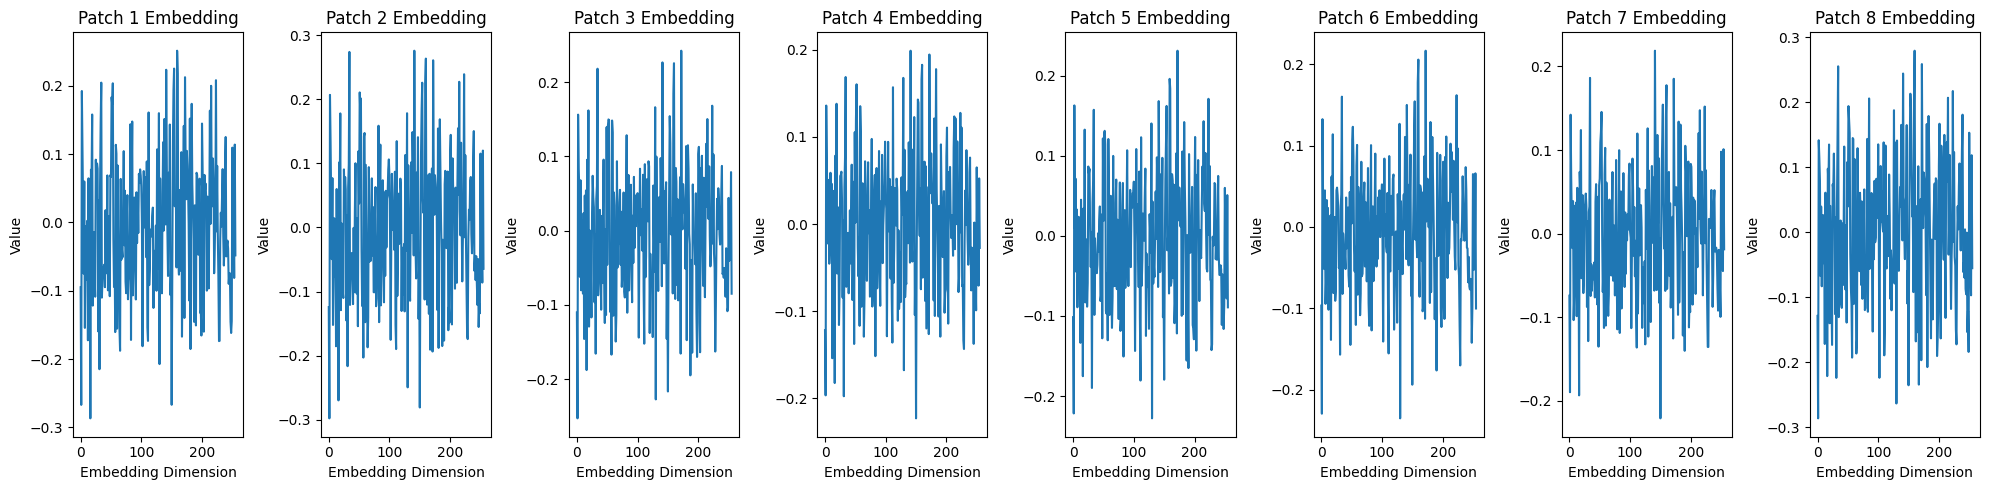

In [25]:
plot_patches(embedded_patches.squeeze(0))

# Postional Embedding

In [26]:
positional_embedding = PositionalEmbedding(num_patches=64, dim=256)
learned_patches = positional_embedding(embedded_patches)

In [27]:
learned_patches.shape

torch.Size([1, 64, 256])

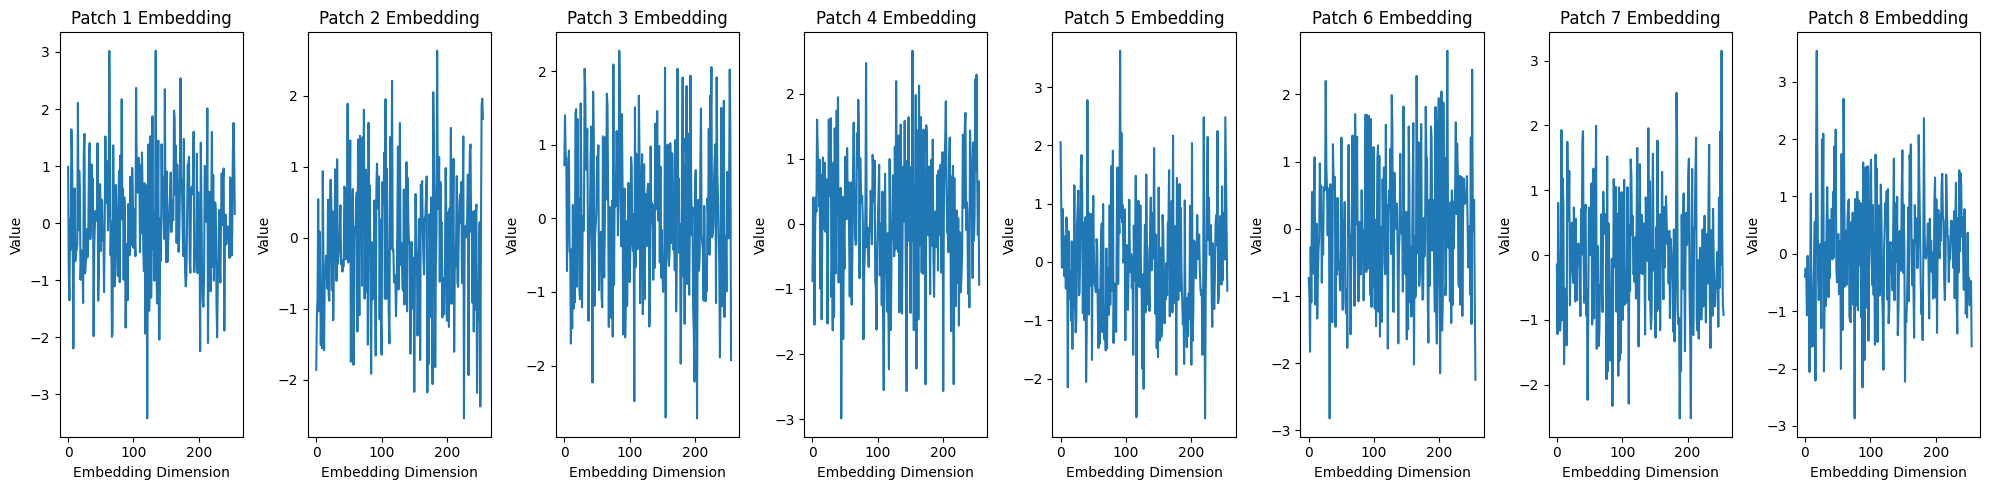

In [28]:
plot_patches(learned_patches.squeeze(0))

# Adaptive MaxVit Block

In [31]:
# Adaptive MaxViT Block
num_heads=4
expansion_factor=4
se_ratio=0.25
mlp_dim=256
adaptive_maxvit_block = AdaptiveMaxViTBlock(embed_dim, num_heads, expansion_factor, se_ratio, mlp_dim)

In [36]:
mbconv = MBConv(embed_dim, embed_dim, expansion_factor, se_ratio)
block_attn = BlockAttention(embed_dim, num_heads)
grid_attn = GridAttention(embed_dim, num_heads)
mlp = nn.Sequential(nn.Linear(embed_dim, mlp_dim), nn.ReLU(), nn.Linear(mlp_dim, embed_dim))
norm = nn.LayerNorm(embed_dim)

In [37]:
x = learned_patches

# Reshape the input to fit the MBConv block
batch_size, num_patches, embed_dim = x.shape
height = width = int(num_patches**0.5)
x = x.view(batch_size, height, width, embed_dim).permute(
    0, 3, 1, 2
)  # Reshape to (batch, embed_dim, height, width)

In [38]:
# MBConv with Squeeze and Excitation
x = mbconv(x)

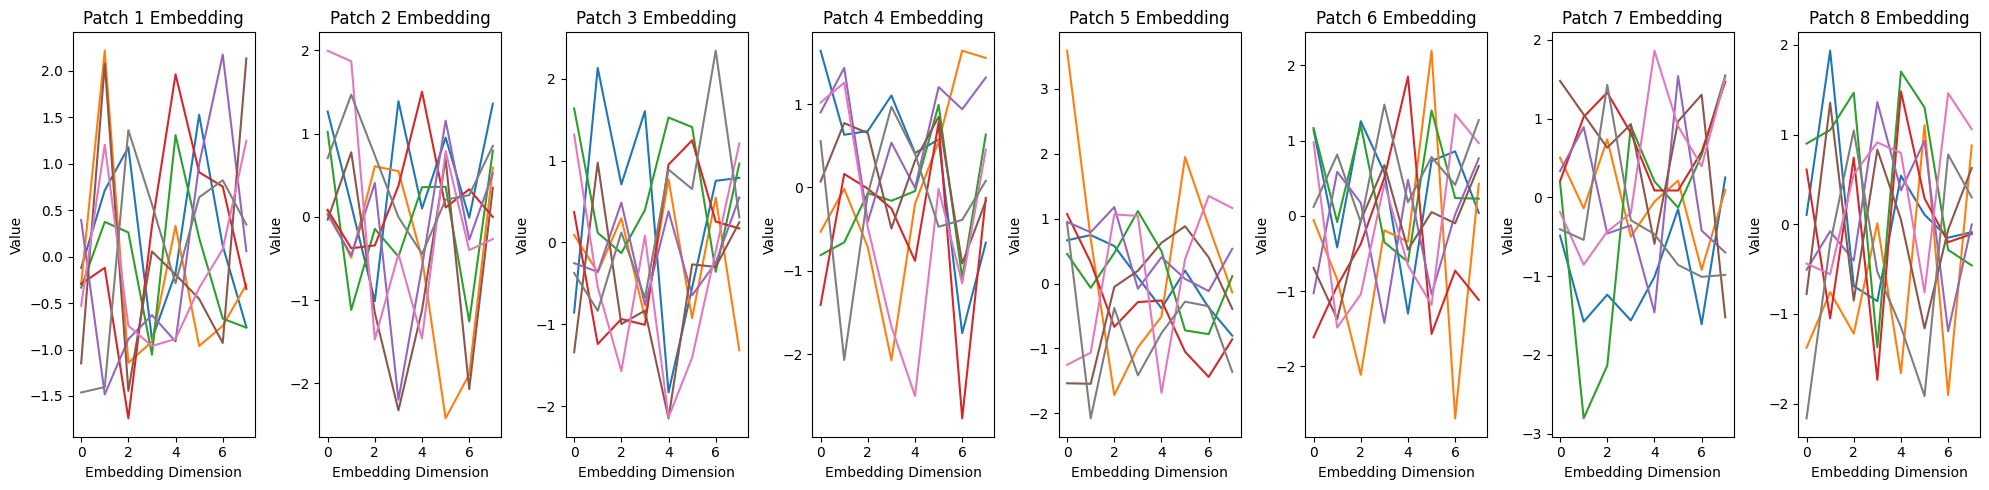

In [40]:
plot_patches(x.squeeze(0))

In [41]:
# Reshape back to (batch_size, num_patches, embed_dim)
x = x.view(batch_size, embed_dim, -1).permute(0, 2, 1)

# Block Attention
x = block_attn(x)

x.shape

torch.Size([1, 64, 256])

In [44]:
# Grid Attention
x = grid_attn(x)

x.shape

torch.Size([1, 64, 256])

In [45]:
mlp_output = mlp(x)
x = norm(x + mlp_output)

x.shape

torch.Size([1, 64, 256])

Why This Approach is Powerful:

Efficiency: Learning in the embedding space is more efficient because the model doesn't have to process every pixel individually. Instead, it works with a compressed, abstract representation of the image.
Flexibility: This method allows the model to generalize better across different scales and contexts since the embeddings capture higher-level features that are more meaningful than raw pixel values.
Parallelization: Transformers can process all patches in parallel, making them highly efficient, especially for large images or complex tasks.

In [32]:
amtb_output = adaptive_maxvit_block(learned_patches)
amtb_output.shape

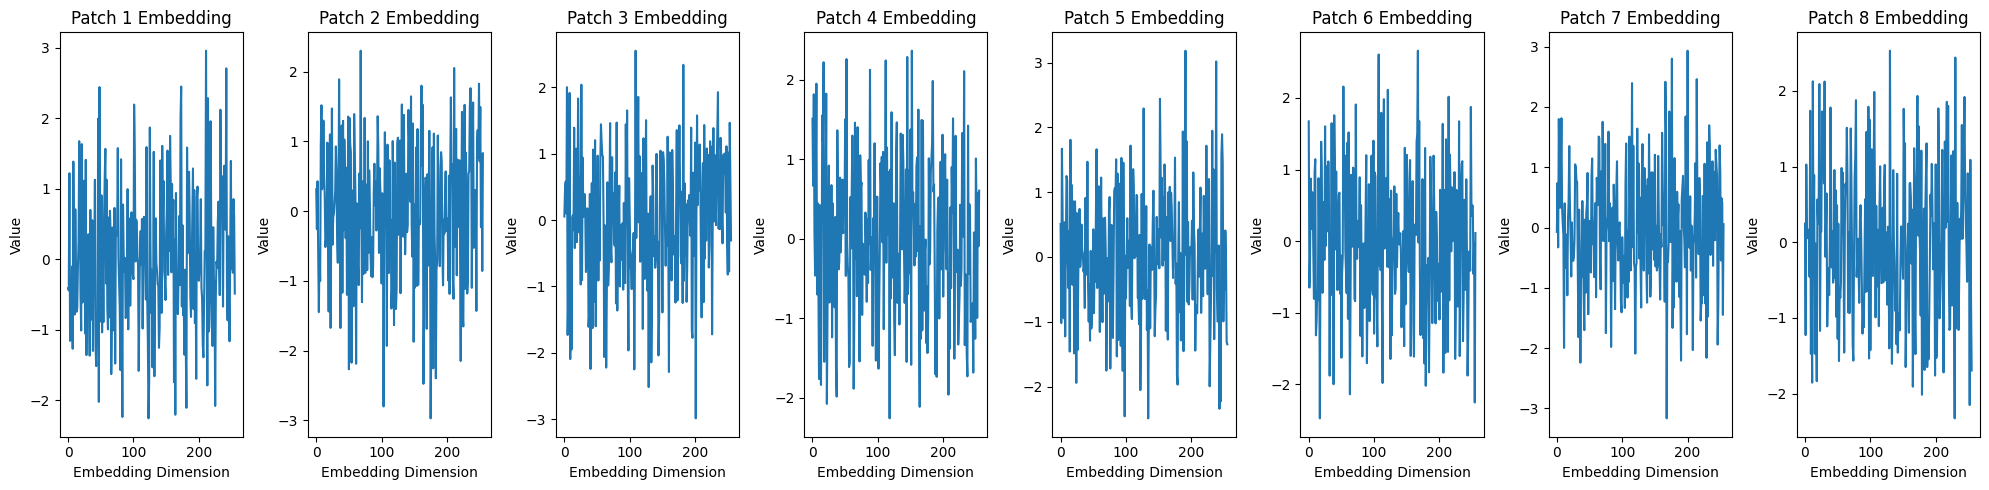

In [34]:
plot_patches(amtb_output.squeeze(0))

# HFFB 

In [47]:
# learn from 1 adaptive MaxVit Block
hffb = HFFB(embed_dim=embed_dim, num_stages=1)


# Step 6: Process through HFFB
fused_features = hffb([x])


In [48]:
fused_features.shape

torch.Size([1, 64, 256])

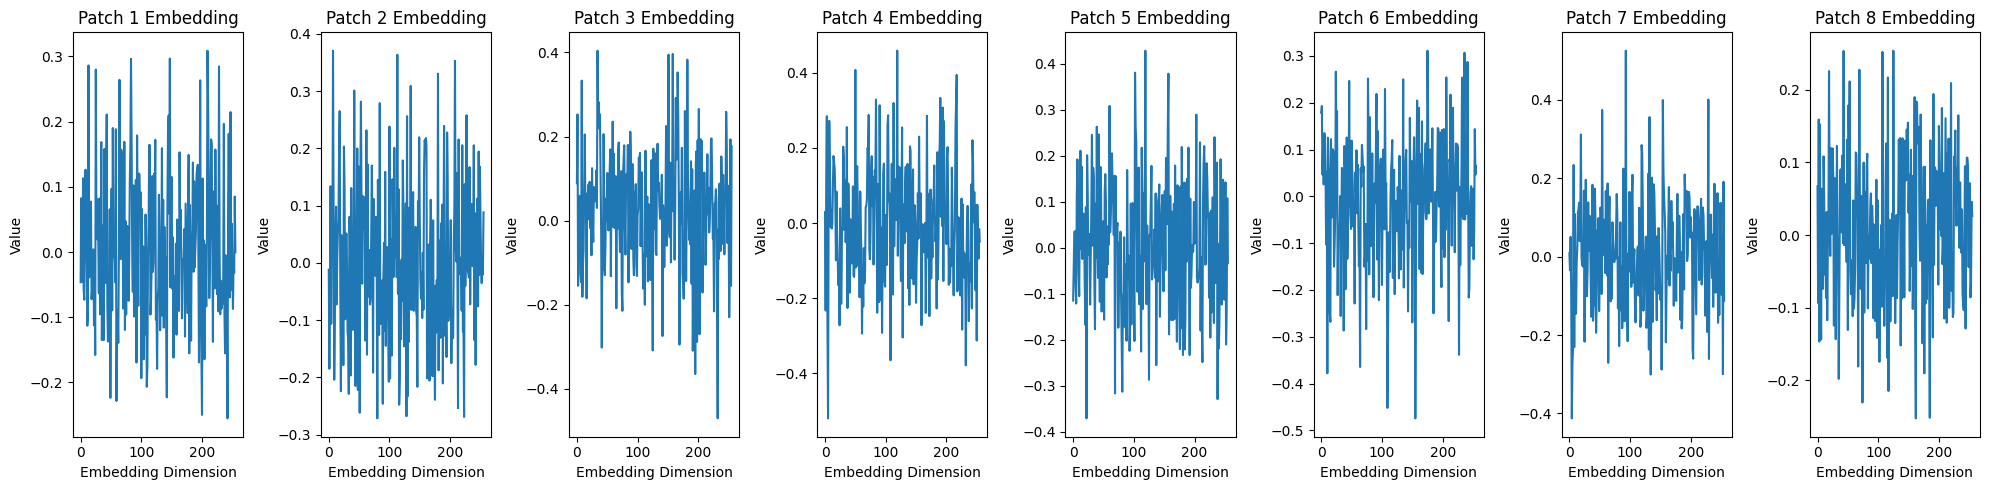

In [49]:
plot_patches(fused_features.squeeze(0))

# Reconstruction Block

In [50]:
# Step 7: Process through Reconstruction Block
reconstruction = ReconstructionBlock(embed_dim, num_patches, patch_size, 3)
output_image = reconstruction(fused_features)

In [51]:
output_image.shape

torch.Size([1, 3, 128, 128])

# Inference

In [55]:
# MaxSR model
# Load the pre-trained weights onto the correct device
model = MaxSRSuperTiny()
model_path = "/home/linuxu/Documents/models/MaxSR-Tiny/20240818_172113/model-checkpoints/model-epoch-558.pth"
# Load the pre-trained weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)


In [56]:
model.eval()

MaxSRSuperTiny(
  (sfe): ShallowFeatureExtractor(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (patch_embeddings): Linear(in_features=4096, out_features=256, bias=True)
  (positional_embedding): PositionalEmbedding()
  (adaptive_maxvit_block): AdaptiveMaxViTBlock(
    (mbconv): MBConv(
      (expand_conv): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1))
      (depthwise_conv): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1024)
      (se_reduce): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
      (se_expand): Conv2d(64, 1024, kernel_size=(1, 1), stride=(1, 1))
      (project_conv): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
      (norm1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (norm2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [58]:
from utils.utils import load_image

In [59]:
with torch.no_grad():
    image = load_image(lr_image_path).to(device)
    output_image = model(image)

In [61]:
# Squeeze the tensor to remove the batch dimension
image_tensor = output_image.squeeze(0)  # This changes the shape to (3, 128, 128)

# Convert the tensor to a PIL Image
# Transpose the tensor to have (H, W, C) format from (C, H, W)
image_tensor = image_tensor.permute(1, 2, 0)
# Scale the tensor from 0-1 (if necessary) and convert to uint8
image_tensor = image_tensor * 255  # Assuming the tensor is scaled between 0 and 1
image_tensor = torch.clamp(image_tensor, 0, 255)
image_tensor = image_tensor.detach().cpu().byte().numpy()

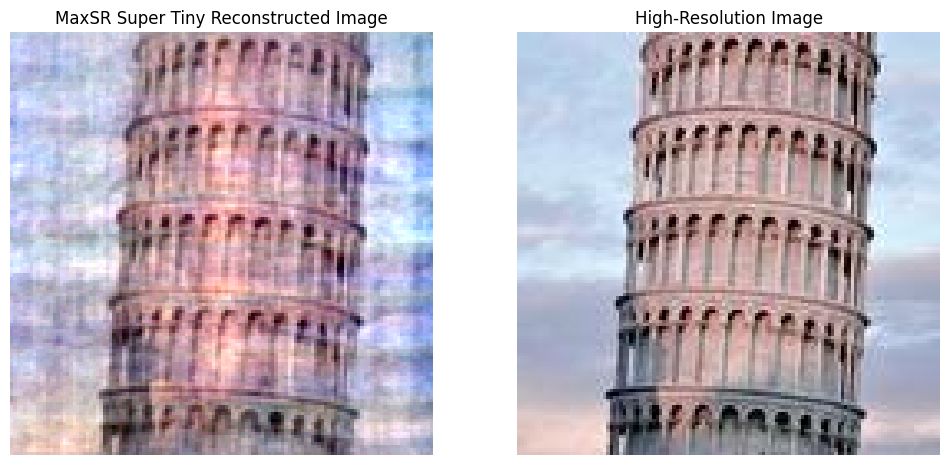

In [65]:
reconstructed_image = Image.fromarray(image_tensor)

# Plot the images side by side
plt.figure(figsize=(12, 6))

# Plot Reconstructed Image
plt.subplot(1, 2, 1)
plt.imshow(reconstructed_image)
plt.title('MaxSR Super Tiny Reconstructed Image')
plt.axis('off')

# Plot High-Resolution Image
plt.subplot(1, 2, 2)
plt.imshow(hr_image)
plt.title('High-Resolution Image')
plt.axis('off')

plt.show()
